<a href="https://colab.research.google.com/github/wagner1986/PapyrusTech/blob/main/ManyLocalFeatureMatcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# !pip install kornia
# !pip install kornia_moons

In [25]:
import time
from contextlib import contextmanager

@contextmanager
def medir_tempo(label: str = "Tempo de execução"):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print(f"{label}: {end - start} segundos")

# Usando o context manager para medir o tempo de execução
with medir_tempo('Processamento concluído'):
    for _ in range(1000000):
        pass

Processamento concluído: 0.08301692300028662 segundos


In [26]:
import torch.nn as nn
import torchvision
import kornia as K
from abc import ABC, abstractmethod
import torch
from kornia import tensor_to_image


import matplotlib.pyplot as plt

def plot_tensor(tensor):
    """
    Plota um tensor PyTorch como uma imagem.

    Parâmetros:
    - tensor (torch.Tensor): Um tensor 2D para imagens em escala de cinza ou um tensor 3D para imagens RGB.
    """
    if tensor.dim() == 2:
        # Imagem em escala de cinza
        plt.imshow(tensor, cmap='gray')
    elif tensor.dim() == 3:
        # Convertendo o tensor de CxHxW para HxWxC para plotagem
        tensor = tensor.permute(1, 2, 0)
        plt.imshow(tensor)
    else:
        raise ValueError("O tensor deve ser 2D (imagem em escala de cinza) ou 3D (imagem RGB).")

    plt.axis('off')  # Remove os eixos para uma visualização mais limpa
    plt.show()

def plot_image_with_keypoints(image, keypoints):
    """
    Plota uma imagem e seus keypoints.

    Parâmetros:
    - image (torch.Tensor): A imagem original.
    - keypoints (torch.Tensor): Os keypoints detectados.
    """
    # Converter a imagem para o formato do matplotlib (H, W, C) e escala [0, 1] se necessário
    if image.dim() == 3:
        image = image.permute(1, 2, 0)
    if torch.max(image) > 1:
        image = image / 255.0

    plt.imshow(image.cpu().numpy())
    if keypoints.dim() == 3:
        keypoints = keypoints[0]  # Se os keypoints estiverem em um batch, pegue apenas o primeiro

    # Plotar os keypoints
    if keypoints.shape[1] == 2:
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20, marker='.', c='r')
    elif keypoints.shape[1] == 3:  # Se os keypoints incluírem a confiança
        plt.scatter(keypoints[:, 0], keypoints[:, 1], s=20 * keypoints[:, 2], marker='.', c='r')

    plt.axis('off')
    plt.show()

In [39]:
from abc import ABC, abstractmethod
from typing import Any, List, Tuple
from itertools import product
import numpy as np
import torch

class IPreprocessor(ABC):
    """
    Interface para um pré-processador de imagens.
    Define o contrato para classes que implementam operações de pré-processamento em imagens.
    """

    @abstractmethod
    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        Aplica operações de pré-processamento à imagem fornecida.

        Parâmetros:
            image (torch.Tensor): A imagem de entrada como um tensor do PyTorch.

        Retorna:
            torch.Tensor: A imagem após o pré-processamento.
        """
        pass

class IGlobalFeatureStructurer(ABC):
    """
    Interface para a estruturação global de features através de grafo.
    """

    @abstractmethod
    def __call__(self, points: np.ndarray, featuresByPoints: np.ndarray) -> Tuple[np.ndarray,Any]:
        """
        Estrutura features globais de uma imagem em um grafo, utilizando pontos e suas características associadas.

        Args:
            points (np.ndarray): Array de pontos extraídos de uma imagem, onde cada ponto é uma coordenada 2D.
            featuresByPoints (np.ndarray): Array de características associadas a cada ponto.

        Returns:
            Tuple[np.ndarray, Any]: Um grafo representando a estruturação global das features e o objeto Delaunay utilizado para a triangulação.
        """
        pass

class IGlobalMatcher(ABC):
    """
    Interface para a similaridade global de features através de grafo.
    """
    @abstractmethod
    def __call__(self, matrixAdj0: np.ndarray, matrixAdj1: np.ndarray, threshold: float = 0.2) -> int:
        """
        Interface para invocar operações de comparação de grafos.

        Args:
            matrixAdj0: A primeira matriz de adjacência do grafo.
            matrixAdj1: A segunda matriz de adjacência do grafo.
            threshold: O limiar para avaliar correspondências.

        Returns:
            Um valor representando a similaridade entre os dois grafos.
        """
        pass


cpu


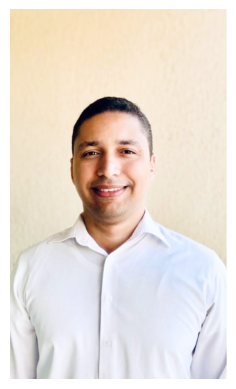

torch.Size([3, 900, 528])
<class 'torch.Tensor'>


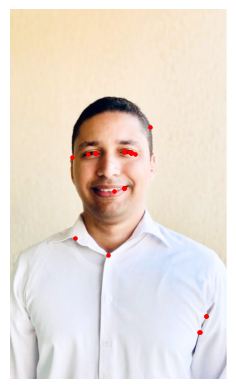

In [28]:
import torch
import torchvision
from kornia.feature import LocalFeatureMatcher, GFTTAffNetHardNet, DescriptorMatcher,KeyNetHardNet

# Supondo que 'device' já esteja definido, por exemplo, device = torch.device('cuda' ou 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print(device)
# Carregando a imagem, convertendo para float e normalizando
image1 = torchvision.io.read_image("image1.jpg").to(torch.float) / 255.0  # Normaliza para [0, 1]
plot_tensor(image1)

image1 = image1.to(device)
print(image1.shape)
gftt_hardnet_matcher = LocalFeatureMatcher(
    GFTTAffNetHardNet(25,device=device), DescriptorMatcher('smnn', 0.8)
)

input = {"image0": image1[:1][None], "image1": image1[:1][None]}# so funciona em escala de cinza
out = gftt_hardnet_matcher(input)
print(type(image1.cpu().data))
plot_image_with_keypoints(image1.cpu(),out['keypoints0'].detach().cpu())


In [29]:
import torch
from kornia.feature import LocalFeature, DescriptorMatcher
from typing import Dict, Optional

class PreprocessPipeline(IPreprocessor):
    def __init__(self):
        super(PreprocessPipeline, self).__init__()
        self.transforms = nn.Sequential(
            # Normaliza a imagem para ter valores no intervalo [0, 1]
            K.enhance.Normalize(0.0, 255.0),
            # Redimensiona a imagem para o tamanho desejado
            K.geometry.Resize((200, 200)),
            # Converte a imagem RGB para escala de cinza , necessario comentar para plotar
            # K.color.RgbToGrayscale(),
        )

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        # Normaliza a imagem para ter valores no intervalo [0, 1]
        x = image#.float() / 255.0  # Garante que a operação de divisão é realizada em float
        # Aplica as transformações definidas em __init__
        x = self.transforms(x)
        # Adiciona uma dimensão de batch no início se ainda não houver
        if x.ndim == 3:
            x = x.unsqueeze(0)
        return x

class MyLocalFeatureMatcher:
    def __init__(self, local_feature: LocalFeature, descriptor_matcher: DescriptorMatcher):
        """
        Inicializa o matcher de características locais com um objeto LocalFeature para extração de características
        e um objeto DescriptorMatcher para o matching de descritores.

        Parâmetros:
            local_feature (LocalFeature): Um objeto LocalFeature para extração combinada de detector e descritor.
            descriptor_matcher (DescriptorMatcher): Um objeto DescriptorMatcher configurado para o matching de descritores.
        """
        self.local_feature = local_feature
        self.descriptor_matcher = descriptor_matcher

    def __call__(self, input) -> Dict[str, torch.Tensor]:
        """
        Extrai e match keypoints e descritores entre duas imagens.

        Args:
            image0: Primeira imagem.
            image1: Segunda imagem.

        Returns:
            Dicionário com keypoints, descritores e matches.
        """
        image0 = input["image0"]
        image1 = input["image1"]
        lafs0, responses0, descriptors0 = self.local_feature(image0)
        lafs1, responses1, descriptors1 = self.local_feature(image1)
        distance, matches = self.descriptor_matcher(descriptors0[0], descriptors1[0])

        return {
            "keypoints0": lafs0[0, :, :, 2].data,#[N, 2])
            "keypoints1": lafs1[0, :, :, 2].data,#[N, 2])
            "lafs0": lafs0,#[1, N, 2, 3]
            "lafs1": lafs1,#[1, N, 2, 3]
            "descriptors0": descriptors0[0],#[N, 128])
            "descriptors1": descriptors1[0],#[N, 128])
            "matches": matches,#[M, 2])
        }

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
class DelaunayGraph(IGlobalFeatureStructurer):
    @staticmethod
    def distancePoint(p1, p2):
        return math.hypot(p1[0] - p2[0], p1[1] - p2[1])

    def buildConnection(self,tri):
        mapConnection = []
        for simplice in tri.simplices:
            mapConnection.extend([
                [simplice[0], simplice[1]],
                [simplice[1], simplice[2]],
                [simplice[2], simplice[0]]
            ])
        return mapConnection

    def buildMapGraph(self, mapConex,featuresByPoints):
        size = len(featuresByPoints)
        sample = np.matrix(np.ones((size, size)) * np.inf)
        for i in range(size):
            sample[i, i] = 0
        for conexao in mapConex:
            distance = self.distancePoint(featuresByPoints[conexao[0]], featuresByPoints[conexao[1]])
            sample[conexao[0], conexao[1]] = distance
        return sample

    @staticmethod
    def plot_delaunay(points, tri):
        plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy(), color='orange')
        plt.plot(points[:, 0], points[:, 1], 'o')
        dist = 3
        for i, point in enumerate(points):
            plt.text(point[0] + dist, point[1] + dist, f' {i}', color='red', fontsize=12)
        plt.show()

    def __call__(self, points, featuresByPoints):
        # Assume-se que os pontos são extraídos de uma imagem e já processados
        tri = Delaunay(points)
        mapConnection = self.buildConnection(tri)
        graph = self.buildMapGraph(mapConnection,featuresByPoints)
        return graph,tri


from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import floyd_warshall
class FloydWarshall(IGlobalMatcher):
    @staticmethod
    def floydWarshall(graph):
        graph = csr_matrix(graph)
        dist_matrix, _ = floyd_warshall(csgraph=graph, directed=False, return_predecessors=True)
        return dist_matrix

    @staticmethod
    def match_matrix(mat_a, mat_b, threshold):
        mat_dist = mat_b - mat_a
        for i in range(mat_dist.shape[0]):
            mat_dist[i, :i] = 0  # Zera a metade inferior da matriz para evitar duplicação
        mat_dist = mat_dist * mat_dist  # Eleva as diferenças ao quadrado
        points = 0
        for i in range(mat_dist.shape[0]):
            for j in range(i + 1, mat_dist.shape[0]):
                if mat_dist[i, j] < threshold:
                    points += 1
        return points

    def __call__(self,matrixAdj0,matrixAdj1, threshold=0.2):
        matAdjFull0 = self.floydWarshall(matrixAdj0)
        matAdjFull1 = self.floydWarshall(matrixAdj1)
        simGraph = self.match_matrix(matAdjFull0,matAdjFull1,threshold)
        return simGraph

cpu
torch.Size([1, 1, 200, 200]) torch.Size([3, 200, 200]) torch.Size([3, 900, 528])
Processamento concluído: 2.6160158080001565 segundos


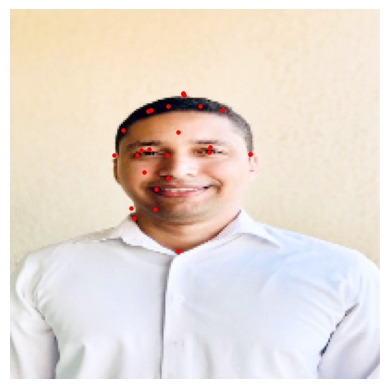

dict_keys(['keypoints0', 'keypoints1', 'lafs0', 'lafs1', 'descriptors0', 'descriptors1', 'matches'])

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
from kornia.feature import SIFTFeatureScaleSpace
my_sift_scale_matcher = MyLocalFeatureMatcher(
    SIFTFeatureScaleSpace(25,device=device), DescriptorMatcher('smnn', 0.8),#GFTTAffNetHardNet, KeyNetHardNet, SIFTFeature, SIFTFeatureScaleSpace
)

image1 = torchvision.io.read_image("image1.jpg").to(device)
image2 = torchvision.io.read_image("image2.jpg").to(device)
image3 = torchvision.io.read_image("image3.jpg").to(device)
pp= PreprocessPipeline()
with medir_tempo('Processamento concluído'):
  image1_p = pp(image1)
  print(image1_p[:,:1].shape,image1_p[0].shape,image1.shape)
  input = {"image0": image1_p[:,:1], "image1":image1_p[:,:1]}
  out = my_sift_scale_matcher(input)

plot_image_with_keypoints(image1_p[0].cpu(),out['keypoints0'].detach().cpu())
out.keys()


#avaliar com e sem gpu ok
#avaliar o pipeline


cpu
torch.Size([1, 1, 200, 200]) torch.Size([3, 200, 200]) torch.Size([3, 900, 528])
Processamento concluído: 2.202633196000079 segundos


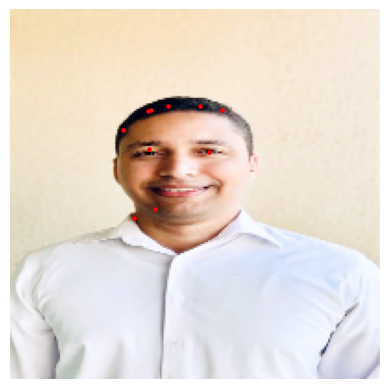

dict_keys(['keypoints0', 'keypoints1', 'lafs0', 'lafs1', 'descriptors0', 'descriptors1', 'matches'])

In [48]:
device = torch.device('cpu')
print(device)
from kornia.feature import SIFTFeatureScaleSpace
my_sift_scale_matcher = MyLocalFeatureMatcher(
    SIFTFeatureScaleSpace(10,device=device), DescriptorMatcher('smnn', 0.8),#GFTTAffNetHardNet, KeyNetHardNet, SIFTFeature, SIFTFeatureScaleSpace
)

image1 = torchvision.io.read_image("image1.jpg").to(device)
pp= PreprocessPipeline()
with medir_tempo('Processamento concluído'):
  image1_p = pp(image1)
  print(image1_p[:,:1].shape,image1_p[0].shape,image1.shape)
  input = {"image0": image1_p[:,:1], "image1":image1_p[:,:1]}
  out = my_sift_scale_matcher(input)

plot_image_with_keypoints(image1_p[0].cpu(),out['keypoints0'].detach().cpu())
out.keys()


#avaliar com e sem gpu
#avaliar o pipeline


In [32]:
delaunayG = DelaunayGraph()  # Inicializa o construtor de grafo de Delaunay
# Compara as matrizes de distância dos dois grafos
floyd = FloydWarshall()

In [49]:


class ImageComparisonPipeline:
    __slots__ = ['preprocessor', 'local_feature_matcher', 'global_structurer', 'global_matcher']

    def __init__(self, preprocessor: IPreprocessor = None, local_feature_matcher: MyLocalFeatureMatcher = None, global_structurer: IGlobalFeatureStructurer = None, global_matcher: IGlobalMatcher = None):
        self.preprocessor = preprocessor
        self.local_feature_matcher = local_feature_matcher
        self.global_structurer = global_structurer
        self.global_matcher = global_matcher

    def process_global(self,out,index):
        pts = out[f'keypoints{index}'][out['matches'][:, index]].detach().numpy()  # Pontos de keypoints correspondentes
        desc = out[f'descriptors{index}'][out['matches'][:, index]].detach().numpy()  # Descritores dos keypoints correspondentes
        matrixAdj, tri = self.global_structurer(pts, desc)
        return matrixAdj

    def run(self, image1: Any, image2: Any,log=None) -> float:
        print(image1.shape,image2.shape)
        if not all([self.preprocessor, self.local_feature_matcher, self.global_structurer, self.global_matcher]):
            raise ValueError("Pipeline components are not fully set.")
        image1_processed, image2_processed = map(self.preprocessor, (image1, image2))

        input = {"image0": image1_processed[:,:1], "image1":image2_processed[:,:1]}
        # Realiza o matching de características entre as duas imagens processadas
        out = self.local_feature_matcher(input)

        if log is not None and log in ('DEBUG','INFO'):
          print(out['keypoints1'].shape,type(out['keypoints1']),'\n',
                out['lafs1'].shape,type(out['lafs1']),'\n',
                out['descriptors1'].shape,type(out['descriptors1']),'\n',
                out['matches'].shape,)
        try:
          matrixAdj0 = self.process_global(out,0)
          matrixAdj1 = self.process_global(out,1)
          score = self.global_matcher(matrixAdj0, matrixAdj1, threshold=0.005)
        except:
          score = 0
        return score

pipeline = ImageComparisonPipeline(pp,my_sift_scale_matcher,delaunayG,floyd)
try:
    similarity_score = pipeline.run(image1, image1)
    print(f"Similarity Score: {similarity_score}")
except Exception as e:
    print(f"Erro durante a execução do pipeline: {e}")

torch.Size([3, 900, 528]) torch.Size([3, 900, 528])
Similarity Score: 45


In [66]:
class ImageComparisonPipeline:
    __slots__ = ['preprocessor', 'local_feature_matcher', 'global_structurer', 'global_matcher']

    def __init__(self, preprocessor=None, local_feature_matcher=None, global_structurer=None, global_matcher=None):
        self.preprocessor = preprocessor
        self.local_feature_matcher = local_feature_matcher
        self.global_structurer = global_structurer
        self.global_matcher = global_matcher

    def process_global(self, out):
        # Simplificação para processar ambos os índices 0 e 1 juntos
        matricesAdj = []
        for index in (0, 1):
            pts = out[f'keypoints{index}'][out['matches'][:, index]].detach().numpy()
            desc = out[f'descriptors{index}'][out['matches'][:, index]].detach().numpy()
            matrixAdj, _ = self.global_structurer(pts, desc)
            matricesAdj.append(matrixAdj)
        return matricesAdj

    def run(self, inspection_images: list, reference_images: list, log=None) -> Dict[tuple, float]:
        if not all([self.preprocessor, self.local_feature_matcher, self.global_structurer, self.global_matcher]):
            raise ValueError("Pipeline components are not fully set.")

        scores = {}
        # Processa todas as imagens antecipadamente
        processed_inspection_images = [self.preprocessor(img) for img in inspection_images]
        processed_reference_images = [self.preprocessor(img) for img in reference_images]

        # Compara cada imagem de inspeção com cada imagem de referência
        for i_index, i_image in enumerate(processed_inspection_images):
            for r_index, r_image in enumerate(processed_reference_images):
                input = {"image0": i_image[:,:1], "image1": r_image[:,:1]}
                out = self.local_feature_matcher(input)

                try:
                    matricesAdj = self.process_global(out)
                    score = self.global_matcher(*matricesAdj, threshold=0.005)
                except:
                    score = 0

                scores[(i_index, r_index)] = score  # Chave é o par de índices (i_index, r_index)

                if log is not None and log in ('DEBUG', 'INFO'):
                    print(f"Score for image pair ({i_index}, {r_index}): {score}")

        return scores

# Suponha que pp, my_sift_scale_matcher, delaunayG, floyd sejam instâncias de suas respectivas classes.
# Suponha também que image1, image2, image3 sejam tensores PyTorch representando imagens.
with medir_tempo('Processamento concluído'):
  pipeline = ImageComparisonPipeline(pp, my_sift_scale_matcher, delaunayG, floyd)
  try:
      similarity_scores = pipeline.run([image1,image2], [image2, image3, image1])
      for pair, score in similarity_scores.items():
          print(f"Similarity Score for pair {pair}: {score}")
  except Exception as e:
      print(f"Erro durante a execução do pipeline: {e}")


Similarity Score for pair (0, 0): 0
Similarity Score for pair (0, 1): 0
Similarity Score for pair (0, 2): 300
Similarity Score for pair (1, 0): 300
Similarity Score for pair (1, 1): 0
Similarity Score for pair (1, 2): 0
Processamento concluído: 12.390822201001356 segundos


In [72]:
from typing import Any, Dict, Tuple
import torch
from kornia.feature import LocalFeature, DescriptorMatcher

class ImageComparisonPipeline:
    __slots__ = ['preprocessor', 'local_feature', 'descriptor_matcher', 'global_structurer', 'global_matcher']

    def __init__(self, preprocessor=None, local_feature: LocalFeature = None, descriptor_matcher: DescriptorMatcher = None, global_structurer=None, global_matcher=None):
        self.preprocessor = preprocessor
        self.local_feature = local_feature
        self.descriptor_matcher = descriptor_matcher
        self.global_structurer = global_structurer
        self.global_matcher = global_matcher

    def process_global(self, out):
        matricesAdj = []
        for index in (0, 1):
            pts = out[f'keypoints{index}'][out['matches'][:, index]].detach().numpy()
            desc = out[f'descriptors{index}'][out['matches'][:, index]].detach().numpy()
            matrixAdj, _ = self.global_structurer(pts, desc)
            matricesAdj.append(matrixAdj)
        return matricesAdj

    def local_feature_matching(self, image0, image1):
        lafs0, responses0, descriptors0 = self.local_feature(image0)
        lafs1, responses1, descriptors1 = self.local_feature(image1)
        distance, matches = self.descriptor_matcher(descriptors0[0], descriptors1[0])
        return {
            "keypoints0": lafs0[0, :, :, 2].data,
            "keypoints1": lafs1[0, :, :, 2].data,
            "lafs0": lafs0,
            "lafs1": lafs1,
            "descriptors0": descriptors0,
            "descriptors1": descriptors1,
            "matches": matches,
        }

    def run(self, inspection_images: list, reference_images: list, log=None) -> Dict[Tuple[int, int], float]:
        if not all([self.preprocessor, self.local_feature, self.descriptor_matcher, self.global_structurer, self.global_matcher]):
            raise ValueError("Pipeline components are not fully set.")

        scores = {}
        processed_inspection_images = [self.preprocessor(img) for img in inspection_images]
        processed_reference_images = [self.preprocessor(img) for img in reference_images]

        for i_index, i_image in enumerate(processed_inspection_images):
            for r_index, r_image in enumerate(processed_reference_images):
                out = self.local_feature_matching(i_image[:,:1], r_image[:,:1])
                print(out['keypoints0'].shape,out['descriptors0'].shape)
                try:
                    matricesAdj = self.process_global(out)
                    score = self.global_matcher(*matricesAdj, threshold=0.005)
                except:
                    score = 0

                scores[(i_index, r_index)] = score

                if log is not None and log in ('DEBUG', 'INFO'):
                    print(f"Score for image pair ({i_index}, {r_index}): {score}")

        return scores


# Suponha que pp, my_sift_scale_matcher, delaunayG, floyd sejam instâncias de suas respectivas classes.
# Suponha também que image1, image2, image3 sejam tensores PyTorch representando imagens.
with medir_tempo('Processamento concluído'):
  pipeline = ImageComparisonPipeline(pp, SIFTFeatureScaleSpace(10,device=device), DescriptorMatcher('smnn', 0.8), delaunayG, floyd)
  try:
      similarity_scores = pipeline.run([image1,image2], [image2, image3, image1])
      for pair, score in similarity_scores.items():
          print(f"Similarity Score for pair {pair}: {score}")
  except Exception as e:
      print(f"Erro durante a execução do pipeline: {e}")


torch.Size([10, 2]) torch.Size([1, 10, 128])
torch.Size([10, 2]) torch.Size([1, 10, 128])
torch.Size([10, 2]) torch.Size([1, 10, 128])
torch.Size([10, 2]) torch.Size([1, 10, 128])
torch.Size([10, 2]) torch.Size([1, 10, 128])
torch.Size([10, 2]) torch.Size([1, 10, 128])
Similarity Score for pair (0, 0): 0
Similarity Score for pair (0, 1): 0
Similarity Score for pair (0, 2): 0
Similarity Score for pair (1, 0): 0
Similarity Score for pair (1, 1): 0
Similarity Score for pair (1, 2): 0
Processamento concluído: 11.357917064999128 segundos
